## Classifying Game Reviews

## 0. Introduction

In this project, we examine the performance of two Bag-of-Words models of text representation: Count vectorization and TF-IDF vectorization, when used in a machine learning model for classifying game reviews.  The classifier model we select is the Logistic Regression Classifier.  The model classifies reviews of digital games as "adult" or "safe", where the decision is based on whether the reviewer deems the game as safe for a child aged 10 or below to play without supervision. 

In [59]:
import warnings

# libraries for general data processing
import numpy as np
import pandas as pd

# libraries for plotting and visualization
import matplotlib.pyplot as plt

# packages for nlp - regex, stopwords and tokenization
import nltk
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# packages for nlp - lemmatization
#nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer 
wordnet_lemmatizer = WordNetLemmatizer()

#warnings.filterwarnings("ignore", category=DeprecationWarning) 

## 1. Retrieving the Reviews Data

The raw reviews data from Commonmedia website which was scraped using ParseHub tool, was manually labelled either "s" (for "safe") or "a" (for "adult").  The criterion was whether the game was suitable for children under age 10 to play without supervision.  Each review included the title and text body, both of which were provided by the reviewers.  The titles which were scraped separately from the review bodies, were merged with the bodies of the reviews, and the processed data was stored in the file "labelled_reviews.csv" in the data folder.

698 reviews were scraped and around 620 were labelled. Some reviews were removed on account of lacking coherent content.  This left us with 606 labelled reviews for the classification project.

In [60]:
# read in the game reviews data
df_rev = pd.read_csv("data/labelled_reviews.csv")
df_rev

,label,title_review
0,a,It’s too scary It's funny but the Car never ha...
1,s,A GOOD RACING GAME!!! Although the movie is no...
2,s,Great game! I think this game is great! My hus...
3,a,"Son loves it, but too violent I am disappointe..."
4,s,Nostalgia. has quite a few explosions (not tha...
...,...,...
601,a,Listen This game is one I am sure a lot of par...
602,s,An epic game that can be for anyone just needs...
603,s,"Amazing game My son wanted the game, At first ..."
604,s,Probably the worst in the franchise but fine f...


## 2. Exploratory Data Analysis

The EDA shows that the median length of reviews labelled 'a' is 94.5 while that of 's' reviews is 56.  This suggests that on average, an 's' review is about 38 words shorter than an 'a' review.

The EDA also shows that of the 606 reviews, the 'a' reviews accounted for about 30%.  This shows there is an imbalance in the response variable.

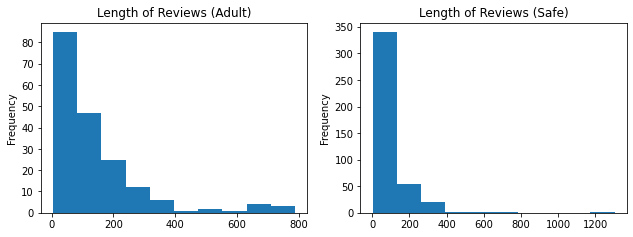

,Length (Adult),Length (Safe)
count,186.000000,420.000000
mean,144.586022,86.435714
std,152.522273,107.236754
min,4.000000,2.000000
25%,50.000000,27.000000
50%,94.500000,56.000000
75%,187.500000,108.250000
max,788.000000,1303.000000


In [61]:
# exploratory analysis on the reviews data - examine lengths of reviews and proportion of reviews labelled "adult" 

# make a copy of the reviews dataframe for exploratory analysis
df_explore = df_rev.copy()

# create a column for tokens of the reviews
df_explore['tokens'] = df_explore['title_review'].map(lambda x: x.split(" "))
# create a column for the length of the review i.e. the number of tokens
df_explore['len'] = df_explore['tokens'].map(len)

# partition the rows according to label being 's' (safe) or 'a' (adult)
df_s = df_explore[ df_explore['label']=='s']
df_a = df_explore[ df_explore['label']=='a']


plt.rcParams["figure.figsize"] = [10.50, 3.50]
fig, axes = plt.subplots(1, 2)
axes[0].set_title( "Length of Reviews (Adult)" )

df_a['len'].plot.hist(ax=axes[0])
axes[1].set_title( "Length of Reviews (Safe)" )
df_s['len'].plot.hist(ax=axes[1])

plt.show()

# show the descriptive statistics of the two groups of reviews
stats_df = pd.concat( [pd.DataFrame( df_a['len'].describe() ), pd.DataFrame( df_s['len'].describe() )], axis=1 )
stats_df.columns = [ 'Length (Adult)', 'Length (Safe)']
stats_df

In [62]:
# investigate data imbalance in the response variable
print( df_rev['label'].value_counts() )
print( df_rev['label'].value_counts(normalize=True) )

s    420
a    186
Name: label, dtype: int64
s    0.693069
a    0.306931
Name: label, dtype: float64


## 3. Preparing Feature Sets

In this section, we carry out the preparation of the features and reponse data for input to the machine learning models.  This involves text processing and preparing word vectors.

### 3.1 Text Processing

We prepare the reviews text for creating the feature vectors.  This involves: tokenization, removal of stopwords, normalization (lower-casing and lemmatization).  The function which does the text processing is preprocess(review).

In [63]:
# preparing the nlp resources: English stopwords
stopwords = set( stopwords.words('english') )
print(list(stopwords))

['further', 'themselves', 'she', 'yourself', 'aren', 'but', "weren't", "you'll", 'his', 'been', 'some', 'herself', 'off', 'these', 'mightn', 'my', 'and', 'will', 'an', 'own', "you've", 'm', 'ourselves', 'most', 'that', "hadn't", 'or', 'above', 'myself', 'll', 'itself', 'up', 'shan', 'other', 'isn', 'o', 've', 'it', 'by', "that'll", 'ours', 'in', 's', 'its', 'below', 'to', 'between', 'why', 'did', "you'd", 'than', 'having', "you're", 'out', 'only', 'so', 'had', 'wouldn', 're', 'ain', 'does', "she's", 'me', "wouldn't", 'yours', "doesn't", 'if', 'is', 'under', 'then', 'all', 'as', 'yourselves', 'from', 'don', "don't", 'just', 'shouldn', "shouldn't", 'into', 'should', 'which', 'you', 'each', 'of', "couldn't", 'are', 'now', 'after', 'was', 'again', 'ma', 'not', 'those', 'mustn', 'before', 'about', "hasn't", 'what', 'nor', 'doing', "didn't", 'during', 'hasn', 'they', "isn't", 'can', 'have', 'weren', 'wasn', "needn't", 'few', "mustn't", "aren't", 'there', 'who', 'once', 'where', 'against', 't

In [64]:
# instantiate the lemmatizer
wn_lemmatizer = WordNetLemmatizer()

In [65]:
# try data prep on one review
rev = df_rev.iloc[140].title_review
rev

"Amazing: Blood can be a bit harsh, but can be fixed with texture mods that also improve graphics in the process. I feel that the Elder Scrolls V: Skyrim is a must play game for all kids ages 10 or eleven and up. It is especially cool for players that are interested in medieval lore or dragons. I've been playing the game for two years now, and haven't come across any sexual encounters at all and the violence isn't that bad, but can be toned down if you're a parent and are worried about your child being influenced towards violent actions. Over all, there are no drugs except for potions such as potions of healing that have no side effects. Alcohol is used and can be bought from a general goods store or tavern, but has the proper negative side effects that will turn people away from making significantly bad life decisions. Great Game!"

In [66]:
rev_tokens = word_tokenize(rev.lower())
print(rev_tokens)

['amazing', ':', 'blood', 'can', 'be', 'a', 'bit', 'harsh', ',', 'but', 'can', 'be', 'fixed', 'with', 'texture', 'mods', 'that', 'also', 'improve', 'graphics', 'in', 'the', 'process', '.', 'i', 'feel', 'that', 'the', 'elder', 'scrolls', 'v', ':', 'skyrim', 'is', 'a', 'must', 'play', 'game', 'for', 'all', 'kids', 'ages', '10', 'or', 'eleven', 'and', 'up', '.', 'it', 'is', 'especially', 'cool', 'for', 'players', 'that', 'are', 'interested', 'in', 'medieval', 'lore', 'or', 'dragons', '.', 'i', "'ve", 'been', 'playing', 'the', 'game', 'for', 'two', 'years', 'now', ',', 'and', 'have', "n't", 'come', 'across', 'any', 'sexual', 'encounters', 'at', 'all', 'and', 'the', 'violence', 'is', "n't", 'that', 'bad', ',', 'but', 'can', 'be', 'toned', 'down', 'if', 'you', "'re", 'a', 'parent', 'and', 'are', 'worried', 'about', 'your', 'child', 'being', 'influenced', 'towards', 'violent', 'actions', '.', 'over', 'all', ',', 'there', 'are', 'no', 'drugs', 'except', 'for', 'potions', 'such', 'as', 'potions

In [67]:
print(nltk.pos_tag(word_tokenize(rev)))

[('Amazing', 'NN'), (':', ':'), ('Blood', 'NN'), ('can', 'MD'), ('be', 'VB'), ('a', 'DT'), ('bit', 'NN'), ('harsh', 'JJ'), (',', ','), ('but', 'CC'), ('can', 'MD'), ('be', 'VB'), ('fixed', 'VBN'), ('with', 'IN'), ('texture', 'NN'), ('mods', 'NNS'), ('that', 'WDT'), ('also', 'RB'), ('improve', 'VBP'), ('graphics', 'NNS'), ('in', 'IN'), ('the', 'DT'), ('process', 'NN'), ('.', '.'), ('I', 'PRP'), ('feel', 'VBP'), ('that', 'IN'), ('the', 'DT'), ('Elder', 'NNP'), ('Scrolls', 'NNP'), ('V', 'NNP'), (':', ':'), ('Skyrim', 'NNP'), ('is', 'VBZ'), ('a', 'DT'), ('must', 'MD'), ('play', 'VB'), ('game', 'NN'), ('for', 'IN'), ('all', 'DT'), ('kids', 'NNS'), ('ages', 'VBZ'), ('10', 'CD'), ('or', 'CC'), ('eleven', 'RB'), ('and', 'CC'), ('up', 'RB'), ('.', '.'), ('It', 'PRP'), ('is', 'VBZ'), ('especially', 'RB'), ('cool', 'JJ'), ('for', 'IN'), ('players', 'NNS'), ('that', 'WDT'), ('are', 'VBP'), ('interested', 'JJ'), ('in', 'IN'), ('medieval', 'JJ'), ('lore', 'NN'), ('or', 'CC'), ('dragons', 'NNS'), ('.

In [68]:
print( wn_lemmatizer.lemmatize("influenced", pos='v'),
       wn_lemmatizer.lemmatize("violent", pos='a'),
       wn_lemmatizer.lemmatize("violent", pos='n'),
       wn_lemmatizer.lemmatize("sexual", pos='n')
     )

influence violent violent sexual


In [69]:
# Function to convert the NLTK POS tags to tags for the lemmatizer
# We will lemmatize according to three classes: verbs, adjectives, and nouns.
# The default word class is nouns.
def get_lemma_pos( pos ):
    pos_map = { 'v': 'v', 'j': 'a', 'n': 'n'}
    return pos_map.get( pos.lower()[0], 'n')

In [70]:
get_lemma_pos("JJ")

'a'

In [71]:
# Preprocessing each review: tokenize, lower-case, remove stopwords and non-alphabetic tokens, lemmatize
def preprocess(review):
    # tokenize
    tokens = word_tokenize(review)
    
    # add the POS - need the tags to properly do the lemmatization by wordnet
    pairs = nltk.pos_tag(tokens)
    
    # lower case the contents of the token-pos pairs
    pairs_lower = [ (pair[0].lower(), pair[1].lower()) for pair in pairs ]
    
    # remove stopwords
    pairs_no_stopwords = [ pair for pair in pairs_lower if pair[0] not in stopwords ]
    # remove tokens that are not fully alphabetic characters - punctuations and numeric 
    alpha_pairs = [ pair for pair in pairs_no_stopwords if pair[0].isalpha() ]
    
    # lemmatize the tokens
    lemmas0 = [ wn_lemmatizer.lemmatize(pair[0], pos=get_lemma_pos( pair[1] ) ) for pair in alpha_pairs ]
    
    # lower case the lemmas
    lemmas = [ str(lemma.lower()) for lemma in lemmas0 ]
    
    # special treatment for word variations of "sex" and "violence" -
    # to standardize 
    for ind, lem in enumerate(lemmas):
        if lem in ["sexual", "sexualize", "sexy", "sexualise"]:
            lemmas[ind] = "sex"
        elif lem=="violent":
            lemmas[ind] = "violence"
            
    return str(lemmas)   # note: the str() format is required by Count- and Tfidf- Vectorizers

In [72]:
print(rev)
print( preprocess(rev) )

Amazing: Blood can be a bit harsh, but can be fixed with texture mods that also improve graphics in the process. I feel that the Elder Scrolls V: Skyrim is a must play game for all kids ages 10 or eleven and up. It is especially cool for players that are interested in medieval lore or dragons. I've been playing the game for two years now, and haven't come across any sexual encounters at all and the violence isn't that bad, but can be toned down if you're a parent and are worried about your child being influenced towards violent actions. Over all, there are no drugs except for potions such as potions of healing that have no side effects. Alcohol is used and can be bought from a general goods store or tavern, but has the proper negative side effects that will turn people away from making significantly bad life decisions. Great Game!
['amazing', 'blood', 'bit', 'harsh', 'fix', 'texture', 'mod', 'also', 'improve', 'graphic', 'process', 'feel', 'elder', 'scroll', 'v', 'skyrim', 'must', 'pla

In [73]:
# pre-process the reviews - tokenization and lemmatization
# create a new column for the result of pre-processing
df_rev['lemmas'] = df_rev['title_review'].map(preprocess)

In [75]:
# check that there are no null rows in the 'lemmas' column
#df_rev[ ~df_rev['lemmas'].isna() ]

In [76]:
# import libraries for feature and data preparation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

# import libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier

# import library for metrics
from sklearn import metrics

In [77]:
# partition the dataframe into response and feature (predictor) sets
X = df_rev['lemmas']
y = df_rev['label']

In [78]:
# split the data into train and test sets
test_size = 0.25
ran_state = 53
X_train, X_test, y_train, y_test = \
     train_test_split(X, y, random_state=ran_state, test_size=test_size, shuffle=True, stratify=y )

In [79]:
X_train

242    ['best', 'forza', 'far', 'favorite', 'forza', ...
38     ['fantastic', 'rpg', 'deliver', 'hard', 'moral...
486    ['word', 'game', 'challenging', 'boss', 'arrow...
152    ['game', 'rat', 'kid', 'maybe', 'something', '...
594    ['think', 'cod', 'great', 'game', 'lot', 'pare...
                             ...                        
413    ['one', 'best', 'video', 'game', 'time', 'get'...
305    ['second', 'favourite', 'game', 'time', 'revie...
40     ['game', 'amazing', 'game', 'review', 'first',...
454    ['perfect', 'kid', 'violence', 'pixel', 'much'...
451    ['violence', 'blood', 'red', 'particle', 'grap...
Name: lemmas, Length: 454, dtype: object

In [80]:
print( y_train.value_counts() )
print( y_train.value_counts(normalize=True) )
print( y_test.value_counts() )
print( y_test.value_counts(normalize=True) )

s    315
a    139
Name: label, dtype: int64
s    0.693833
a    0.306167
Name: label, dtype: float64
s    105
a     47
Name: label, dtype: int64
s    0.690789
a    0.309211
Name: label, dtype: float64


### 3.2 Feature Vectorizers: CountVectorizer, Normalized CountVectorizer, TfidfVectorizer 

In this section, we transform the preprocessed reviews to vectors using CountVectorizer and TfidfVectorizer.  Since the EDA has shown that length of reviews is correlated with the response variable, we will examine the effect of normalizing the vectors formed by CountVectorizer against the number of tokens in the review vector (using L2 norm).

In [81]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.05)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

In [82]:
# Initialize count vectorizer, with counts normalized against review length (L2 norm)
count_norm_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.05, use_idf=False, norm='l2')

# Create count train and test variables
count_norm_train = count_norm_vectorizer.fit_transform(X_train)
count_norm_test = count_norm_vectorizer.transform(X_test)

# Initialize tfidf vectorizer, with tf's normalized by length of text (L2 norm)
# tfidf_norm_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.9, min_df=0.05, use_idf=True, norm='l2')

# NOTE: Tfidf vectorizer is by default normalized to L2 norm.  So we do not need to create normalized tfidf vectors.
# Create tfidf train and test variables
# tfidf_norm_train = tfidf_norm_vectorizer.fit_transform(X_train)
# tfidf_norm_test = tfidf_norm_vectorizer.transform(X_test)

# Create an IDF dataframe for examining the idf values for the tokens
# df_idf = pd.DataFrame(tfidf_norm_vectorizer.idf_, 
#                      index=tfidf_norm_vectorizer.get_feature_names_out(),columns=["idf_weights"]) 
# display the idfs in ascending order
##print( df_idf.sort_values(by=['idf_weights']).to_string() )

In [83]:
print(len(count_vectorizer.vocabulary_), count_vectorizer.get_feature_names_out())

104 ['actually' 'age' 'amazing' 'awesome' 'bad' 'best' 'bit' 'blood' 'buy'
 'car' 'character' 'child' 'come' 'content' 'control' 'definitely'
 'different' 'drug' 'easy' 'enemy' 'enjoy' 'fact' 'fight' 'fine' 'forza'
 'fun' 'game' 'gameplay' 'good' 'gore' 'graphic' 'great' 'halo' 'handle'
 'hard' 'hear' 'help' 'hour' 'include' 'kid' 'kill' 'know' 'language'
 'let' 'life' 'like' 'little' 'long' 'look' 'lot' 'love' 'main' 'make'
 'mature' 'mild' 'mode' 'multiplayer' 'need' 'new' 'old' 'online'
 'overall' 'parent' 'people' 'play' 'player' 'point' 'pretty' 'probably'
 'problem' 'quite' 'rat' 'rating' 'real' 'really' 'reason' 'recommend'
 'review' 'role' 'say' 'series' 'sex' 'shoot' 'start' 'story' 'swearing'
 'teen' 'theme' 'thing' 'think' 'time' 'try' 'turn' 'use' 'video'
 'violence' 'want' 'war' 'watch' 'way' 'word' 'world' 'year' 'young']


## 4. Machine Learning Models

We compare the performance of four models which are well-used for text classification: Logistic Regression, Naive Bayes, Complement Naive Bayes (adapted for imbalanced data), Random Forest.  We carry out a 5-fold cross validation on each model on each set of training vectors (count, normalized count, tfidf).

In [88]:
# define custom functions for machine learning

import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Function to carry out cross validation evaluation on training a model (meant for training/validation dataset)
# Metrics are: f1_mean, f1_std, accuracy
def crossvalidate_classifier(model, X, y, cv=5, cm=False):
    
    # carry out training the model and evaluate by cross validation
    f1_scores = cross_val_score(model, X, y, scoring='f1_macro', cv=cv)
    
    # get the metric scores: f1_mean, f1_std, accuracy
    print("{}-fold cross validation results:".format(str(cv)))
    print("%0.2f f-1 score with a standard deviation of %0.2f" % (f1_scores.mean(), f1_scores.std()))
    y_pred = cross_val_predict(model, X, y, cv=cv)
    acc_score = round( metrics.accuracy_score(y_pred, y), 3)
    print("accuracy score {}".format(acc_score))
    
    # display the confusion matrix
    if(cm):
        conf_mat = confusion_matrix(y, y_pred, labels=['a', 's'])
        disp = ConfusionMatrixDisplay(conf_mat, display_labels=['a', 's'])
        disp.plot()
        plt.show()
    
    # return the three scores
    return round(f1_scores.mean(), 3), round(f1_scores.std(), 3), acc_score

# Fit a model on the training data, and evaluate on the test set
# Metrics are: f1_macro, accuracy, confusion matrix
# Returns the fitted model
def evaluate_classifier(model, X_train, X_test, y_train, y_test):
      
    # ... fit the model here
    model.fit(X_train,y_train)

    # Run predict on your test data to get the predictions
    pred = model.predict(X_test)

    # Compute the f1_macro scores
    f1score = round( metrics.f1_score(pred, y_test, average='macro'), 3)
    print("F-1 Score: {}".format(f1score))
    
    # Calculate accuracy score
    acc_score = round( metrics.accuracy_score(pred, y_test), 3)
    print("Accuracy Score: {}".format(acc_score))
    
    # Calculate the confusion matrice
    cm = confusion_matrix(y_test, pred, labels=['a','s'])

    # Plot the confusion matrix using the plot_confusion_matrix function
    display = ConfusionMatrixDisplay(cm, display_labels=['a', 's'])
    display.plot()
    plt.show()
    
    return model

# Grid search for the optimal hyperparameters
# Returns the fitted models
def best_hyperparam(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='f1_macro',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        return_train_score=True
    )
    
    gs.fit(X_train_data, y_train_data)
    
    return gs


In [89]:
# Function to invoke the cross validation of training models,
#   iterating over a models list and over a feature-sets list.
# Returns a data frame containing the scores (f1_mean, f1_std, accuracy)
#   for models and feature-sets

def cvtrain_models_ds( models_dict, dataset_dict, y_train ):
    
    f1_mean = [0]*len(models_dict)
    f1_std = [0]*len(models_dict)
    acc_score = [0]*len(models_dict)

    scores_list = []
    model_names = list( models_dict.keys() )
    ds_names = list(dataset_dict.keys())
    score_names = ["f1_mean", "f1_std", "accuracy"]
    
    for j, dataset_name in enumerate(ds_names):
        for i, model_name in enumerate(model_names):
            print("\nCross-validating " + dataset_name + " " + model_name)
            f1_mean[i], f1_std[i], acc_score[i] = \
                 crossvalidate_classifier(models_dict[model_name], dataset_dict[dataset_name], y_train)


        scores_data = { "f1_mean" : f1_mean, "f1_std" : f1_std, "accuracy": acc_score }
        scores_df = pd.DataFrame(scores_data, index=model_names)
        scores_list.append(scores_df)
        print("------------------------------------")
    
    # create a hierarchical index for the column names
    hier_cols_index = pd.MultiIndex.from_product([ds_names, score_names], names=["TrainDs", "Score"])
    # concatenate the scores dfs for the feature-sets
    concat_scores_df = pd.concat(scores_list, axis=1)
    # rename the columns of the concatenated dataframe
    concat_scores_df.columns = hier_cols_index
    
    return concat_scores_df


In [90]:
# selected models
lr_clf = LogisticRegression(class_weight="balanced", random_state=54)
nb_clf = MultinomialNB()
cnb_clf = ComplementNB()
rfr_clf = RandomForestClassifier(class_weight = {'a': 3, 's': 1}, random_state=54)

models_data = { "LogisticRegression": lr_clf,
                "NaiveBayes" : nb_clf,
                "CompNaiveBayes" : cnb_clf,
                "RandomForest": rfr_clf }
X_train_sets = { "Tfidf_Train" : tfidf_train,
                 "Count_Train" : count_train,
                 #"Tfidf_Norm_Train" : tfidf_norm_train,
                 "Count_Norm_Train" : count_norm_train }

all_scores_df = cvtrain_models_ds(models_data, X_train_sets, y_train )
all_scores_df



Cross-validating Tfidf_Train LogisticRegression
5-fold cross validation results:
0.68 f-1 score with a standard deviation of 0.03
accuracy score 0.707

Cross-validating Tfidf_Train NaiveBayes
5-fold cross validation results:
0.56 f-1 score with a standard deviation of 0.03
accuracy score 0.731

Cross-validating Tfidf_Train CompNaiveBayes
5-fold cross validation results:
0.67 f-1 score with a standard deviation of 0.03
accuracy score 0.689

Cross-validating Tfidf_Train RandomForest
5-fold cross validation results:
0.60 f-1 score with a standard deviation of 0.05
accuracy score 0.709
------------------------------------

Cross-validating Count_Train LogisticRegression
5-fold cross validation results:
0.64 f-1 score with a standard deviation of 0.05
accuracy score 0.687

Cross-validating Count_Train NaiveBayes
5-fold cross validation results:
0.70 f-1 score with a standard deviation of 0.03
accuracy score 0.749

Cross-validating Count_Train CompNaiveBayes
5-fold cross validation results:

TrainDs            Tfidf_Train                 Count_Train                  \
Score                  f1_mean f1_std accuracy     f1_mean f1_std accuracy   
LogisticRegression       0.677  0.035    0.707       0.640  0.052    0.687   
NaiveBayes               0.561  0.027    0.731       0.698  0.028    0.749   
CompNaiveBayes           0.669  0.028    0.689       0.682  0.024    0.709   
RandomForest             0.601  0.053    0.709       0.600  0.026    0.714   

TrainDs            Count_Norm_Train                  
Score                       f1_mean f1_std accuracy  
LogisticRegression            0.687  0.041    0.716  
NaiveBayes                    0.506  0.044    0.722  
CompNaiveBayes                0.663  0.036    0.692  
RandomForest                  0.613  0.038    0.725

### 4.1 Model Selection and Evaluation

Comparing the mean F1 scores of the models in the above table, we see that Naive Bayes trained on count vectors has the highest F1-score of 0.698.  But on the other hand, the same model has the lowest score of 0.506 when trained on the normalized Count vectors.  The low score is close to the F1-score of 0.561 for the NB model trained on TF-IDF vectors.  This suggests that the good performance of Naive Bayes might have been due to the effect of length.  If this is true, then the NB model will not generalize well to data which have short reviews.

Since the Logistic Regression (LR) has consistently good performance across the training sets, and since there exist feature weights which are available for gaining some degree of explainability, we choose the LR model as the classifier.

Next, we evaluate the LR model using the test sets of the feature types.  The metrics are F1-score and Accuracy.  The confusion matrix is displayed as well.

F-1 Score: 0.667
Accuracy Score: 0.697


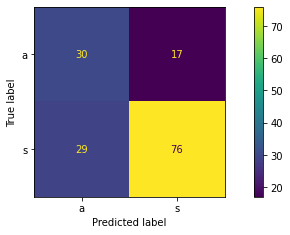

In [91]:
# Here, we train the LR model on the Count (or BOW) vectors
lr_count_model = LogisticRegression(class_weight="balanced", random_state=54)
lr_count_model = evaluate_classifier(lr_count_model, count_train, count_test, y_train, y_test)

F-1 Score: 0.733
Accuracy Score: 0.757


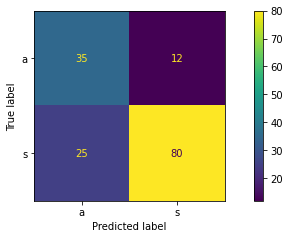

In [92]:
# LR model is trained on the normalized Count vectors
lr_model = LogisticRegression(class_weight="balanced", random_state=54)
lr_count_norm_model = evaluate_classifier(lr_model, count_norm_train, count_norm_test, y_train, y_test)

F-1 Score: 0.721
Accuracy Score: 0.743


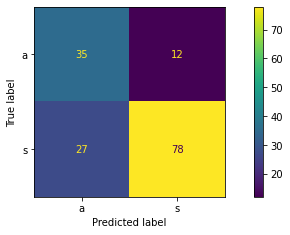

In [93]:
# LR model trained on the tfidf vectors
lr_tfidf_model = LogisticRegression(class_weight="balanced", random_state=54)
lr_tfidf_model = evaluate_classifier(lr_tfidf_model, tfidf_train, tfidf_test, y_train, y_test)

### 4.2 Summary of Evaluation Results:

The LR model trained on the normalized Count-vectors have the best F1 score of 0.733, which is followed very closely by the score of 0.721 from the model trained on TF-IDF vectors.  The confusion matrices of both models are very similar and show that the TF-IDF is erring on the side of caution for having 2 more false positives (where positive='a') than the count-normalized model.  The accuracy scores of the two models are also very close: 0.757 and 0.721.  All of this suggest that the TF-IDF vectors are very similar to the normalized Count vectors in this dataset.  This also suggest that the IDF (inverse document frequency) does not make much a difference for this collection of reviews.  Indeed, the quick look (section 4.2.1) at the distribution of the IDF values show a limited range of \[1.61, 3.942\], with more than 50% idfs being greater than 3.

The F1-score and accuracy for the LR model trained on the (unnormalized) Count-vectors are 0.667 and 0.697 respectively.  Clearly the performance falls below that of the previous two models.  

#### 4.2.1 A Quick Look at the IDF Values

,count,mean,std,min,25%,50%,75%,max
idf_weights,104.0,3.309975,0.566312,1.161873,3.035244,3.444077,3.788093,3.942244


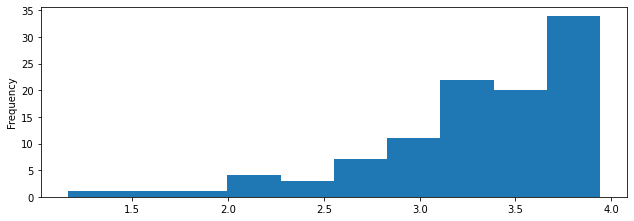

In [94]:
# Create an IDF dataframe for examining the idf values for the tokens
df_idf = pd.DataFrame(tfidf_vectorizer.idf_, 
                      index=tfidf_vectorizer.get_feature_names_out(),columns=["idf_weights"])
df_idf['idf_weights'].plot.hist()
df_idf.describe().T

### 4.3 A Deeper Look at the Models: Feature Weights

The top 15 features for reviews labelled "adult" and top 15 features for reviews labelled "safe" are retrieved from the three fitted LR models.

For the Count-vector model, the top words for "adult" reviews include meaningful words such as "teen", "gore", "language", "mature".  However, other words such as "try", "turn", "use" are harder to explain.

For the normalized Count-vector and TF-IDF models, the top 15 words for "a" reviews are the same, although differing in order of size of the weights.

Comparing the top 15 words for 'a' reviews between the Count model and the normalized models, we see that the three words from the Count model: "come", "try", "main", are replaced by these words in the normalized models: "violence", "child", "player".  It seems to me that the last three words are more semantically attuned to the domain and their meanings readily account for the "a" label.

In [95]:
# Investigate the feature weights for the LR model trained on the Count vectors
coefs_dict = dict(zip(count_vectorizer.get_feature_names_out(), lr_count_model.coef_[0]))
sorted_coefs = sorted(coefs_dict.items(), key=lambda x: x[1], reverse=True) 

print("\nTop 15 words for reviews labelled adult")
print(sorted_coefs[-15:][::-1])

print("\nTop 15 words for reviews labelled safe")
print(sorted_coefs[:15])


Top 15 words for reviews labelled adult
[('teen', -1.4039939235717436), ('shoot', -0.9754331766464568), ('gore', -0.8843202664368648), ('turn', -0.8835241248169712), ('make', -0.868457849461591), ('language', -0.7895603875094064), ('come', -0.773067012620972), ('mature', -0.7659229427850953), ('story', -0.6936049950292896), ('use', -0.6829394407735039), ('enemy', -0.6718492301748236), ('try', -0.6651576130068109), ('lot', -0.6038862096956533), ('content', -0.5755299241986711), ('main', -0.5143088163725179)]

Top 15 words for reviews labelled safe
[('help', 1.4449896169859036), ('thing', 1.20492422280601), ('easy', 1.1331910224595656), ('fight', 0.9219800238201943), ('mild', 0.8716134237860206), ('new', 0.8244250556798354), ('point', 0.8093636612184412), ('forza', 0.7790459376316256), ('start', 0.7759995779998722), ('review', 0.7688440343085989), ('rat', 0.7012373532426067), ('old', 0.6914215317829202), ('video', 0.6468736607655752), ('life', 0.6441037217360815), ('online', 0.572511116

In [96]:
# Investigate the feature weights for the LR model trained on the L2-normalized Count vectors
coefs_dict = dict(zip(count_norm_vectorizer.get_feature_names_out(), lr_count_norm_model.coef_[0]))
sorted_coefs = sorted(coefs_dict.items(), key=lambda x: x[1], reverse=True) 

print("\nTop 15 words for reviews labelled adult")
print(sorted_coefs[-15:][::-1])

print("\nTop 15 words for reviews labelled safe")
print(sorted_coefs[:15])


Top 15 words for reviews labelled adult
[('gore', -1.7565054244653489), ('turn', -1.7243127045677695), ('mature', -1.6816021833154209), ('make', -1.6561702420721083), ('language', -1.6517010055422803), ('child', -1.5667033518831364), ('teen', -1.3961561940107268), ('player', -1.3471259203018722), ('enemy', -1.3379052268194156), ('violence', -1.3163198327381491), ('story', -1.252176537001595), ('lot', -1.2134306835621176), ('shoot', -1.0876463801837617), ('use', -1.004293143450446), ('content', -0.999659007565982)]

Top 15 words for reviews labelled safe
[('fun', 1.0997745544843203), ('forza', 1.0191659560242061), ('easy', 0.9544251400779301), ('amazing', 0.8835142675813705), ('new', 0.8821386999722853), ('thing', 0.8453807713868864), ('mild', 0.7803914552116076), ('rat', 0.684618190380124), ('bad', 0.5874639269050685), ('old', 0.5857265546630639), ('review', 0.5510806650797918), ('fight', 0.5212206971594896), ('world', 0.5206682176810844), ('real', 0.4911608538779104), ('start', 0.479

In [97]:
# Investigate the feature weights for the LR model trained on the Tf-idf vectors
coefs_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), lr_tfidf_model.coef_[0]))
sorted_coefs = sorted(coefs_dict.items(), key=lambda x: x[1], reverse=True) 

print("\nTop 15 words for reviews labelled adult")
print(sorted_coefs[-15:][::-1])

print("\nTop 15 words for reviews labelled safe")
print(sorted_coefs[:15])


Top 15 words for reviews labelled adult
[('turn', -1.7137922201233693), ('mature', -1.66923038350814), ('teen', -1.6543198726652864), ('gore', -1.5993047274266112), ('make', -1.5922081430976482), ('language', -1.5587273086126578), ('violence', -1.4029698043811987), ('child', -1.3828675828488388), ('enemy', -1.309547462059202), ('player', -1.2888188230891562), ('shoot', -1.2733721642260034), ('story', -1.2439123575057285), ('lot', -1.173846458040536), ('use', -1.067393484923065), ('content', -0.9702637170902642)]

Top 15 words for reviews labelled safe
[('fun', 1.2433815184068355), ('easy', 1.0677845635069934), ('forza', 1.0387625858990346), ('new', 1.0353656692946884), ('thing', 0.9857505762648137), ('amazing', 0.8569488163819692), ('game', 0.8366311156762215), ('rat', 0.7969404611012841), ('mild', 0.7591945524054364), ('start', 0.6719715723919066), ('fight', 0.6455577088722014), ('bad', 0.637423516004415), ('review', 0.6309382047556553), ('old', 0.5853231178319025), ('help', 0.545052

## 5. Conclusion

In this project, we compare the performance of two Bag-of-Words (BOW) models for text representation in a classification task: Count vs TF-IDF.  The task is to classify a review as expressing whether the game under review is safe or otherwise.  The reviews dataset contains 605 reviews, which we split into train/test sets in the ratio 0.75:0.25.  Logistic Regression (LR) is selected as the classifier model.

The results of classification are summarized in the following table:

| Metric | Count | TF-IDF | Count (normalized) |
| --- | --- | --- | --- |
| F1-Score | .667  | .733 | .721 |
| Accuracy | .697 | .757 | .743 |

The metrics show that the TF-IDF outperforms the Count model on both F1-score and Accuracy.  On the other hand, the performance of TF-IDF is very close to the L2-normalized Count vectors.  On examining the distribution of the IDF values of the TF-IDF model, we see that the IDFs have a limited range of \[1.61, 3.942\], with more than 50% of the values being larger than 3.0.  This suggests that IDF does not have much impact in this set of reviews.  Hence, the disparity in performance between Count and TF-IDF might be explained by feature normalization or lack thereof.  In other words, the boost in performance of the LR model is accounted for by feature scaling.  

We have shown that the TF-IDF model is better suited for this application.  It is conceivable that where feature scaling is not important e.g. in Random Forest models, the Count model could outperform the TF-IDF model.  So, the decision of which model is better really depends on the use case.

Overall, the performance of the BOW models in this classification task is not impressive.  A major reason is certainly the small size of the dataset.  Other reasons are well known to be the limitations of BOW models such as violation of feature independence assumptions, and lack of representation for word context and word order.